In [15]:
import numpy as np
import pandas as pd
# Keras 
from sklearn.model_selection import train_test_split
# transformer ML libraries
import tensorflow as tf
from transformers import AutoTokenizer
# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [16]:
train = pd.read_csv('/kaggle/input/twitter-disaster-dataset-competition/train.csv')
test = pd.read_csv('/kaggle/input/twitter-disaster-dataset-competition/test.csv')

In [17]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
train = train[['text' , 'target']]

In [19]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
train.isnull().sum()

text      0
target    0
dtype: int64

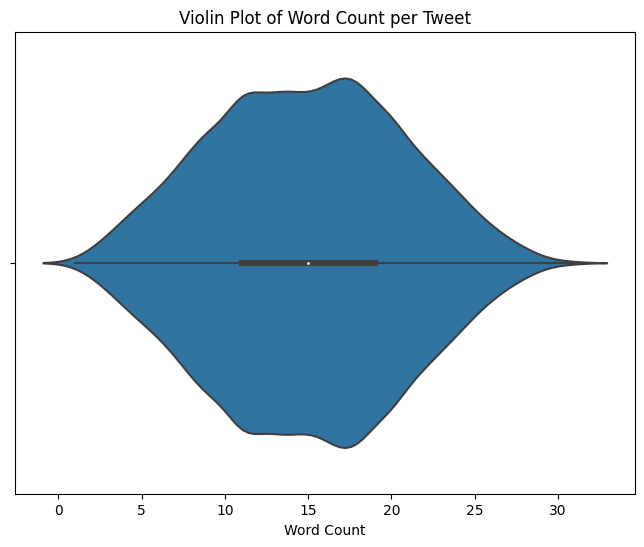

In [21]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

# Calculate the statistics
plt.figure(figsize=(8, 6))
sns.violinplot(x=train['word_count'])
plt.title('Violin Plot of Word Count per Tweet')
plt.xlabel('Word Count')
plt.show()

In [22]:
max_length = 35
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
texts = list(train['text'])
labels = list(train['target'])
encoded_inputs = tokenizer(
    texts,
    max_length=max_length,            # Set maximum sequence length to 40 tokens
    padding='max_length',     # Pad sequences to the maximum length
    truncation=True,          # Truncate sequences longer than the maximum length
    return_tensors='np'       # Return NumPy arrays (use 'tf' for TensorFlow tensors directly)
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

In [24]:
print("Input IDs:", input_ids[0])
print("Attention Mask:", attention_mask[0])

Input IDs: [  101  3458  9115  3680  1132  1103 21642  1104  1142   108  8386  1318
 18589 10783  3048  1370  5389  2707  1366  1155   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0]
Attention Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
df = pd.DataFrame({
    'input_ids': list(input_ids),
    'attention_mask': list(attention_mask),
    'labels': labels  # Ensure this is a list or array
})

In [26]:
def create_tf_dataset_from_df(df, batch_size=32):
    input_ids = tf.convert_to_tensor(np.array(df['input_ids'].tolist()), dtype=tf.int32)
    attention_mask = tf.convert_to_tensor(np.array(df['attention_mask'].tolist()), dtype=tf.int32)
    labels = tf.convert_to_tensor(np.array(df['labels']), dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        },
        labels
    ))
    dataset = dataset.batch(batch_size)
    return dataset
train_dataset_tf = create_tf_dataset_from_df(df, batch_size=32)

In [27]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Step 5: Model Training
history = model.fit(
    train_dataset_tf,
    epochs=2,
    validation_data=None
)

Epoch 1/2
238/238 [==============================] - 57s 119ms/step - loss: 0.5375 - accuracy: 0.7387
Epoch 2/2
238/238 [==============================] - 28s 116ms/step - loss: 0.3923 - accuracy: 0.8329


In [29]:
# now its time to predict : 

SyntaxError: invalid syntax (976450023.py, line 1)

In [32]:
test = test[['id','text']]
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
test_texts = list(test['text'])  # Assuming `test` DataFrame contains the test data
encoded_test_inputs = tokenizer(
    test_texts,
    max_length=max_length,            # Use the same max_length as in training
    padding='max_length',             # Pad sequences to the maximum length
    truncation=True,                  # Truncate sequences longer than the maximum length
    return_tensors='np'               # Return NumPy arrays (use 'tf' for TensorFlow tensors directly)
)

In [34]:
test_input_ids = encoded_test_inputs['input_ids']
test_attention_mask = encoded_test_inputs['attention_mask']

In [35]:
test_predictions = model.predict(
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask}
)


102/102 [==============================] - 8s 39ms/step


In [36]:
test_predictions_labels = (tf.nn.softmax(test_predictions.logits, axis=-1)[:, 1] > 0.5).numpy().astype(int)

In [37]:
output_df = pd.DataFrame({
    'id': test['id'],  # Assuming `test` DataFrame has an 'id' column
    'target': test_predictions_labels
})


In [38]:
output_df.to_csv('submission.csv', index=False)

In [40]:
pred = pd.read_csv('/kaggle/working/submission.csv')
pred.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
